In [6]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import os
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import make_interp_spline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import calendar

%matplotlib inline
plt.style.use('default')

In [7]:
def load_data_from_db(db_path, year='2024'):
    try:
        conn = sqlite3.connect(db_path)
        query = f"SELECT * FROM combined_tracks WHERE begin_date LIKE '{year}%'"
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
    except sqlite3.Error as e:
        print(f"Database error: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()


In [9]:
# Load data from SQLite database
df = load_data_from_db('/users/shasharma/personal/combined_tracks_2024-new.db')
print(f"Loaded {len(df)} records from database")

# Convert date strings to datetime objects with ISO format
df['begin_date'] = pd.to_datetime(df['begin_date'], format='ISO8601')
df['end_date'] = pd.to_datetime(df['end_date'], format='ISO8601')
df['duration'] = (df['end_date'] - df['begin_date']).dt.total_seconds()

# Filter out very short sessions (less than 3 second)
df = df[df['duration'] >= 1]
df = df.sort_values('begin_date')

print("\nBasic statistics:")
print(df.describe())

Loaded 441067 records from database

Basic statistics:
            track_id       duration
count  388928.000000  388928.000000
mean    84038.278381      41.719078
std     45999.042766     200.988350
min         1.000000       1.000000
25%     47506.000000       3.000000
50%     80410.500000       6.018000
75%    115156.000000      23.000000
max    193407.000000   32725.245000


In [10]:
def merge_fragmented_sessions(df, time_threshold=5, consider_title=False):
    """
    Merge sessions that are fragmented due to brief interruptions (e.g., alt-tabbing).
    
    Parameters:
    - df: DataFrame containing the sessions
    - time_threshold: Maximum time gap (in seconds) to consider as an interruption
    - consider_title: Whether to consider window title in addition to app name
    
    Returns:
    - DataFrame with merged sessions
    """
    if consider_title:
        df['app_title'] = df['app'] + " - " + df['title']
        key_field = 'app_title'
    else:
        key_field = 'app'
    
    df_sorted = df.sort_values(['begin_date'])
    sessions = []
    
    for key, group in df_sorted.groupby(key_field):
        group = group.sort_values('begin_date')
        
        current_session = {
            'app': group.iloc[0]['app'],
            'title': group.iloc[0]['title'],
            'begin_date': group.iloc[0]['begin_date'],
            'end_date': group.iloc[0]['end_date'],
            'device': group.iloc[0]['device'],
            'task_name': group.iloc[0]['task_name']
        }
        
        for i in range(1, len(group)):
            row = group.iloc[i]
            time_diff = (row['begin_date'] - current_session['end_date']).total_seconds()
            
            if time_diff <= time_threshold:
                current_session['end_date'] = row['end_date']
            else:
                current_session['duration'] = (current_session['end_date'] - current_session['begin_date']).total_seconds()
                sessions.append(current_session)
                
                current_session = {
                    'app': row['app'],
                    'title': row['title'],
                    'begin_date': row['begin_date'],
                    'end_date': row['end_date'],
                    'device': row['device'],
                    'task_name': row['task_name']
                }
        
        current_session['duration'] = (current_session['end_date'] - current_session['begin_date']).total_seconds()
        sessions.append(current_session)
    
    return pd.DataFrame(sessions)

def handle_overlapping_sessions(df):
    """
    Process the dataframe to handle overlapping sessions across devices and calculate
    accurate total usage time without double counting overlaps.
    """
    # Sort by begin_date to process chronologically
    sorted_df = df.sort_values('begin_date').copy()
    
    # Convert to list of sessions with begin and end times
    sessions = sorted_df[['begin_date', 'end_date', 'app', 'device', 'title']].values.tolist()
    
    # Merge overlapping time intervals
    merged_intervals = []
    if sessions:
        current = sessions[0].copy()
        for session in sessions[1:]:
            # If current session overlaps with next one
            if current[1] >= session[0]:
                # Extend the current session if needed
                current[1] = max(current[1], session[1])
            else:
                # No overlap, add current to results and start new current
                merged_intervals.append(current)
                current = session.copy()
        # Add the last session
        merged_intervals.append(current)
    
    # Calculate total non-overlapping time
    total_time = sum((interval[1] - interval[0]).total_seconds() for interval in merged_intervals)
    
    return pd.DataFrame(merged_intervals, columns=['begin_date', 'end_date', 'app', 'device', 'title']), total_time


In [11]:
# Merge fragmented sessions
merged_df_app_only = merge_fragmented_sessions(df, consider_title=False)
merged_df_with_title = merge_fragmented_sessions(df, consider_title=True)

print(f"Original number of records: {len(df)}")
print(f"Records after merging (app only): {len(merged_df_app_only)}")
print(f"Records after merging (app + title): {len(merged_df_with_title)}")

# Use app-only merged data for analysis
merged_df = merged_df_app_only
non_overlapping_df, total_non_overlapping_time = handle_overlapping_sessions(merged_df)
total_hours_non_overlapping = total_non_overlapping_time / 3600

print(f"Total hours tracked (with potential overlaps): {merged_df['duration'].sum() / 3600:.2f}")
print(f"Total hours tracked (removing overlaps): {total_hours_non_overlapping:.2f}")
print(f"Difference due to overlaps: {(merged_df['duration'].sum() / 3600) - total_hours_non_overlapping:.2f} hours")


Original number of records: 388928
Records after merging (app only): 156529
Records after merging (app + title): 336784
Total hours tracked (with potential overlaps): 4518.28
Total hours tracked (removing overlaps): 4400.94
Difference due to overlaps: 117.34 hours


In [12]:
# Extract date parts for time-based analysis
merged_df = merged_df[merged_df['app'] != 'IDLE']

merged_df['date'] = merged_df['begin_date'].dt.date
merged_df['hour'] = merged_df['begin_date'].dt.hour
merged_df['day_of_week'] = merged_df['begin_date'].dt.dayofweek
merged_df['week'] = merged_df['begin_date'].dt.isocalendar().week
merged_df['month'] = merged_df['begin_date'].dt.month

def calculate_daily_usage(df):
    daily_usage = df.groupby('date')['duration'].sum().reset_index()
    daily_usage['hours'] = daily_usage['duration'] / 3600
    return daily_usage

def calculate_weekly_usage(df):
    weekly_usage = df.groupby(['week'])['duration'].sum().reset_index()
    weekly_usage['hours'] = weekly_usage['duration'] / 3600
    return weekly_usage

def calculate_hourly_distribution(df):
    hourly_dist = df.groupby('hour')['duration'].sum().reset_index()
    hourly_dist['percentage'] = hourly_dist['duration'] / hourly_dist['duration'].sum() * 100
    return hourly_dist

def calculate_day_of_week_distribution(df):
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_dist = df.groupby('day_of_week')['duration'].sum().reset_index()
    dow_dist['day_name'] = dow_dist['day_of_week'].apply(lambda x: day_names[x])
    dow_dist['percentage'] = dow_dist['duration'] / dow_dist['duration'].sum() * 100
    dow_dist['hours'] = dow_dist['duration'] / 3600
    return dow_dist

daily_usage = calculate_daily_usage(merged_df)
weekly_usage = calculate_weekly_usage(merged_df)
hourly_dist = calculate_hourly_distribution(merged_df)
dow_dist = calculate_day_of_week_distribution(merged_df)


/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/2608182983.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['date'] = merged_df['begin_date'].dt.date
/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/2608182983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['hour'] = merged_df['begin_date'].dt.hour
/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/2608182983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [13]:
def set_figure_properties(fig, ax, bg_color, text_color, grid_color):
    ax.set_facecolor(bg_color)
    fig.set_facecolor(bg_color)
    for spine in ax.spines.values():
        spine.set_color(grid_color)
    ax.tick_params(colors=text_color)
    ax.xaxis.label.set_color(text_color)
    ax.yaxis.label.set_color(text_color)
    ax.title.set_color(text_color)
    return fig, ax

def get_theme_colors(theme='light'):
    if theme == 'light':
        plt.style.use('default')
        return {
            'bg_color': 'white',
            'text_color': '#333333',
            'grid_color': '#E0E0E0',
            'color_palette': 'viridis',
            'accent_color': '#1E88E5',
            'alpha': 0.8
        }
    else:
        plt.style.use('dark_background')
        return {
            'bg_color': '#121212',
            'text_color': '#E0E0E0',
            'grid_color': '#333333',
            'color_palette': 'plasma',
            'accent_color': '#00E5FF',
            'alpha': 0.9
        }

os.makedirs('visualizations_light', exist_ok=True)
os.makedirs('visualizations_dark', exist_ok=True)

In [14]:
def plot_hourly_distribution(hourly_dist, theme='light', show_plot=True):
    colors = get_theme_colors(theme)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    custom_cmap = sns.color_palette(colors['color_palette'], as_cmap=True)
    norm = plt.Normalize(0, 23)
    color_values = [custom_cmap(norm(h)) for h in hourly_dist['hour']]
    
    for i, (hour, row) in enumerate(hourly_dist.iterrows()):
        rect = Rectangle((hour-0.4, 0), 0.8, row['percentage'], 
                        facecolor=color_values[i], alpha=colors['alpha'], edgecolor='none')
        ax.add_patch(rect)
    
    for i, (hour, row) in enumerate(hourly_dist.iterrows()):
        reflection = Rectangle((hour-0.4, 0), 0.8, row['percentage']*0.05, 
                              facecolor='white', alpha=0.1, edgecolor='none')
        ax.add_patch(reflection)
    
    x = hourly_dist['hour']
    y = hourly_dist['percentage']
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)  # A cubic spline
    y_smooth = spline(x_smooth)
    
    ax.plot(x_smooth, y_smooth, color=colors['accent_color'], linewidth=2.5, alpha=0.7)
    
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentage of Total Usage', fontsize=12, fontweight='bold')
    ax.set_title('Computer Usage Distribution by Hour of Day (2024)', fontsize=16, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.4, color=colors['grid_color'])
    
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 24)], rotation=45)
    
    ax.set_ylim(0, hourly_dist['percentage'].max() * 1.15)
    
    for i, row in hourly_dist.iterrows():
        if row['percentage'] > hourly_dist['percentage'].max() * 0.1:  # Only label significant bars
            ax.text(row['hour'], row['percentage'] + 0.5, f'{row["percentage"]:.1f}%', 
                   ha='center', va='bottom', color=colors['text_color'], fontsize=9, fontweight='bold')
    
    fig, ax = set_figure_properties(fig, ax, colors['bg_color'], colors['text_color'], colors['grid_color'])
    plt.tight_layout()
    
    output_dir = f'visualizations_{theme}'
    plt.savefig(f'{output_dir}/hourly_distribution.png', dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    return fig

In [24]:
def plot_day_hour_heatmap(merged_df, theme='light', show_plot=True):
    colors = get_theme_colors(theme)
    fig, ax = plt.subplots(figsize=(20, 8))
    
    day_hour_data = []
    for day_of_week in range(7):
        day_df = merged_df[merged_df['day_of_week'] == day_of_week].copy()
        for hour in range(24):
            hour_df = day_df[day_df['hour'] == hour].copy()
            if not hour_df.empty:
                _, non_overlapping_time = handle_overlapping_sessions(hour_df)
                hours_value = non_overlapping_time / 3600
                day_hour_data.append({
                    'day_of_week': day_of_week,
                    'hour': hour,
                    'hours': hours_value
                })
    
    day_hour_df = pd.DataFrame(day_hour_data)
    
    heat_data = day_hour_df.pivot(index='day_of_week', columns='hour', values='hours').fillna(0)
    
    for hour in range(24):
        if hour not in heat_data.columns:
            heat_data[hour] = 0
    
    heat_data = heat_data.sort_index(axis=1)
    
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heat_data = heat_data.reindex(range(7))
    
    if theme == 'light':
        cmap = 'YlOrRd'
    else:
        cmap = sns.color_palette(colors['color_palette'], as_cmap=True)
    
    heatmap = sns.heatmap(
        heat_data, 
        cmap=cmap, 
        annot=True,
        fmt='.1f',
        linewidths=0.5,
        linecolor='white' if theme == 'light' else 'gray',
        ax=ax,
        cbar=False,
    )
    
    ax.set_title('Computer Usage by Day of Week and Hour of Day (2024)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Day of Week', fontsize=12, fontweight='bold')
    
    time_labels = [f'{int(h):02d}:00' for h in range(24)]
    ax.set_xticklabels(time_labels, rotation=45, ha='right')  # Align like in example
    
    ax.set_yticklabels(day_names)
    
    fig.set_facecolor(colors['bg_color'])
    ax.set_facecolor(colors['bg_color'])
    
    plt.tight_layout()
    
    output_dir = f'visualizations_{theme}'
    plt.savefig(f'{output_dir}/day_hourly_heatmap.png', dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    print("\nHeatmap Statistics:")
    
    total_hours = heat_data.sum().sum()
    print(f"Total hours logged: {total_hours:.2f}")
    
    print("\nTop 5 most active time slots:")
    
    # Stack the dataframe to get (day, hour) pairs
    stacked_data = heat_data.stack().reset_index()
    stacked_data.columns = ['day_of_week', 'hour', 'hours']
    stacked_data['day_name'] = stacked_data['day_of_week'].apply(lambda x: day_names[x])
    
    # Get top 5
    top_5 = stacked_data.nlargest(5, 'hours')
    for _, row in top_5.iterrows():
        print(f"{row['day_name']} at {int(row['hour']):02d}:00 - {row['hours']:.2f} hours")
    
    return fig

In [25]:
def plot_monthly_usage(merged_df, theme='light', show_plot=True):
    colors = get_theme_colors(theme)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    merged_df['month_name'] = merged_df['begin_date'].dt.strftime('%b')
    merged_df['month_num'] = merged_df['begin_date'].dt.month
    
    monthly_data = merged_df.groupby('month_num').agg({
        'duration': 'sum',
        'month_name': 'first'
    }).reset_index()
    
    monthly_data['hours'] = monthly_data['duration'] / 3600
    monthly_data = monthly_data.sort_values('month_num')
    
    bars = ax.bar(monthly_data['month_name'], monthly_data['hours'], 
                 color=sns.color_palette(colors['color_palette'], len(monthly_data)),
                 alpha=colors['alpha'], width=0.7)
    
    ax.plot(monthly_data['month_name'], monthly_data['hours'], 'o-', 
            color=colors['accent_color'], linewidth=2.5, markersize=8)
    
    avg_monthly = monthly_data['hours'].mean()
    avg_line_color = '#E53935' if theme == 'light' else '#FF5252'
    ax.axhline(y=avg_monthly, color=avg_line_color, 
               linestyle='--', linewidth=2, alpha=0.7,
               label=f'Monthly Average: {avg_monthly:.1f}h')
    
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Hours', fontsize=12, fontweight='bold')
    ax.set_title('Monthly Computer Usage (2024)', fontsize=16, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.4, color=colors['grid_color'])
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}h', ha='center', va='bottom', color=colors['text_color'], 
               fontsize=10, fontweight='bold')
    
    ax.legend(loc='best', facecolor=colors['bg_color'], edgecolor=colors['grid_color'])
    
    fig, ax = set_figure_properties(fig, ax, colors['bg_color'], colors['text_color'], colors['grid_color'])
    plt.tight_layout()
    
    output_dir = f'visualizations_{theme}'
    plt.savefig(f'{output_dir}/monthly_usage.png', dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    return fig

In [26]:
def plot_calendar_heatmap(merged_df, theme='light', show_plot=True):
    colors = get_theme_colors(theme)
    
    # Calculate daily total durations in seconds, then convert to hours
    daily_data = []
    for date in sorted(merged_df['date'].unique()):
        day_df = merged_df[merged_df['date'] == date]
        # Get the duration in seconds and convert to hours
        day_sessions, duration_seconds = handle_overlapping_sessions(day_df)
        hours = duration_seconds / 3600  # Convert seconds to hours
        daily_data.append({
            'date': date,
            'hours': hours
        })
    
    daily_df = pd.DataFrame(daily_data)
    print(daily_df)
    
    start_date = datetime(2024, 1, 1).date()
    end_date = datetime(2024, 12, 31).date()
    all_dates = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
    full_daily_df = pd.DataFrame({'date': all_dates})
    full_daily_df = full_daily_df.merge(daily_df, on='date', how='left').fillna(0)
    full_daily_df['month'] = [d.month for d in full_daily_df['date']]
    full_daily_df['day'] = [d.day for d in full_daily_df['date']]
    full_daily_df['weekday'] = [d.weekday() for d in full_daily_df['date']]
    
    if theme == 'light':
        cmap = LinearSegmentedColormap.from_list('github', [
            '#ebedf0',
            '#9be9a8',
            '#40c463',
            '#30a14e',
            '#216e39'
        ])
    else:
        cmap = LinearSegmentedColormap.from_list('github_dark', [
            '#161b22',
            '#0e4429',
            '#006d32',
            '#26a641',
            '#39d353'
        ])
    
    max_hours = max(8, full_daily_df['hours'].max())
    activity_levels = [0, max_hours/4, max_hours/2, max_hours*3/4, max_hours]
    
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor(colors['bg_color'])
    
    gs = gridspec.GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.2)
    
    weekdays = ['M', 'T', 'W', 'T', 'F', 'S', 'S']
    
    for month_idx in range(1, 13):
        month_data = full_daily_df[full_daily_df['month'] == month_idx]
        month_name = calendar.month_abbr[month_idx]
        row = (month_idx - 1) // 3
        col = (month_idx - 1) % 3
        ax = fig.add_subplot(gs[row, col])
        ax.set_facecolor(colors['bg_color'])

        first_day = datetime(2024, month_idx, 1).date()
        first_weekday = first_day.weekday()  # Monday is 0
        days_in_month = calendar.monthrange(2024, month_idx)[1]
        weeks_needed = (days_in_month + first_weekday + 6) // 7
        square_size = 0.95
        padding = 0.05

        ax.set_xlim(-0.5, 7 * (square_size + padding))
        ax.set_ylim(weeks_needed * (square_size + padding) - padding + 0.5, -0.5)
        
        for day in range(1, days_in_month + 1):
            date_obj = datetime(2024, month_idx, day).date()
            weekday = date_obj.weekday()
            week = (day + first_weekday - 1) // 7
            
            day_data = month_data[month_data['day'] == day]
            hours = 0 if day_data.empty else day_data.iloc[0]['hours']
            
            color_idx = np.sum(hours > np.array(activity_levels)) - 1
            color_idx = max(0, color_idx)  # Ensure non-negative
            color = cmap(color_idx / (len(activity_levels) - 1))
            
            x = weekday * (square_size + padding)
            y = week * (square_size + padding)
            
            # Draw square
            rect = Rectangle((x, y), square_size, square_size, 
                            facecolor=color, edgecolor='none', alpha=0.9)
            ax.add_patch(rect)
            
            ax.text(x + square_size/2, y + square_size*0.35, str(day), 
                   ha='center', va='center', color=colors['text_color'],
                   fontsize=6, fontweight='bold')
            
            if hours > 0:
                ax.text(x + square_size/2, y + square_size*0.7, f"{hours:.1f}", 
                       ha='center', va='center', color=colors['text_color'],
                       fontsize=5, alpha=0.7)
        
        for i, day in enumerate(weekdays):
            ax.text(i * (square_size + padding) + square_size/2, -0.3, day,
                   ha='center', va='center', color=colors['text_color'],
                   fontsize=7, alpha=0.7)
            
        ax.set_title(month_name, fontsize=10, fontweight='bold', 
                    color=colors['text_color'], pad=2)
    
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
    
    fig.suptitle('Daily Computer Usage (2024)', fontsize=14, 
                fontweight='bold', color=colors['text_color'], y=0.98)
    
    total_days = len(full_daily_df)
    active_days = len(full_daily_df[full_daily_df['hours'] > 0])
    total_hours = full_daily_df['hours'].sum()
    avg_hours = total_hours / active_days if active_days > 0 else 0
    
    stats_text = (
        f"Days tracked: {active_days}/{total_days} ({active_days/total_days*100:.1f}%) | "
        f"Total: {total_hours:.1f}h | "
        f"Avg: {avg_hours:.1f}h/day"
    )
    
    fig.text(0.5, 0.01, stats_text, ha='center', 
            color=colors['text_color'], fontsize=9, alpha=0.8)
    
    plt.tight_layout(rect=[0, 0.02, 0.90, 0.96])
    
    output_dir = f'visualizations_{theme}'
    plt.savefig(f'{output_dir}/calendar_heatmap.png', dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    return fig, full_daily_df

In [27]:
def create_all_visualizations(daily_usage, weekly_usage, hourly_dist, dow_dist, merged_df, theme='light', show_plots=True):
    figures = []
    
    print(f"Creating {theme} theme visualizations...")
    figures.append(plot_hourly_distribution(hourly_dist, theme, show_plots))
    figures.append(plot_monthly_usage(merged_df, theme, show_plots))
    figures.append(plot_day_hour_heatmap(merged_df, theme, show_plots))

    fig, _ = plot_calendar_heatmap(merged_df, theme)
    figures.append(fig)
    
    return figures

Creating light theme visualizations...


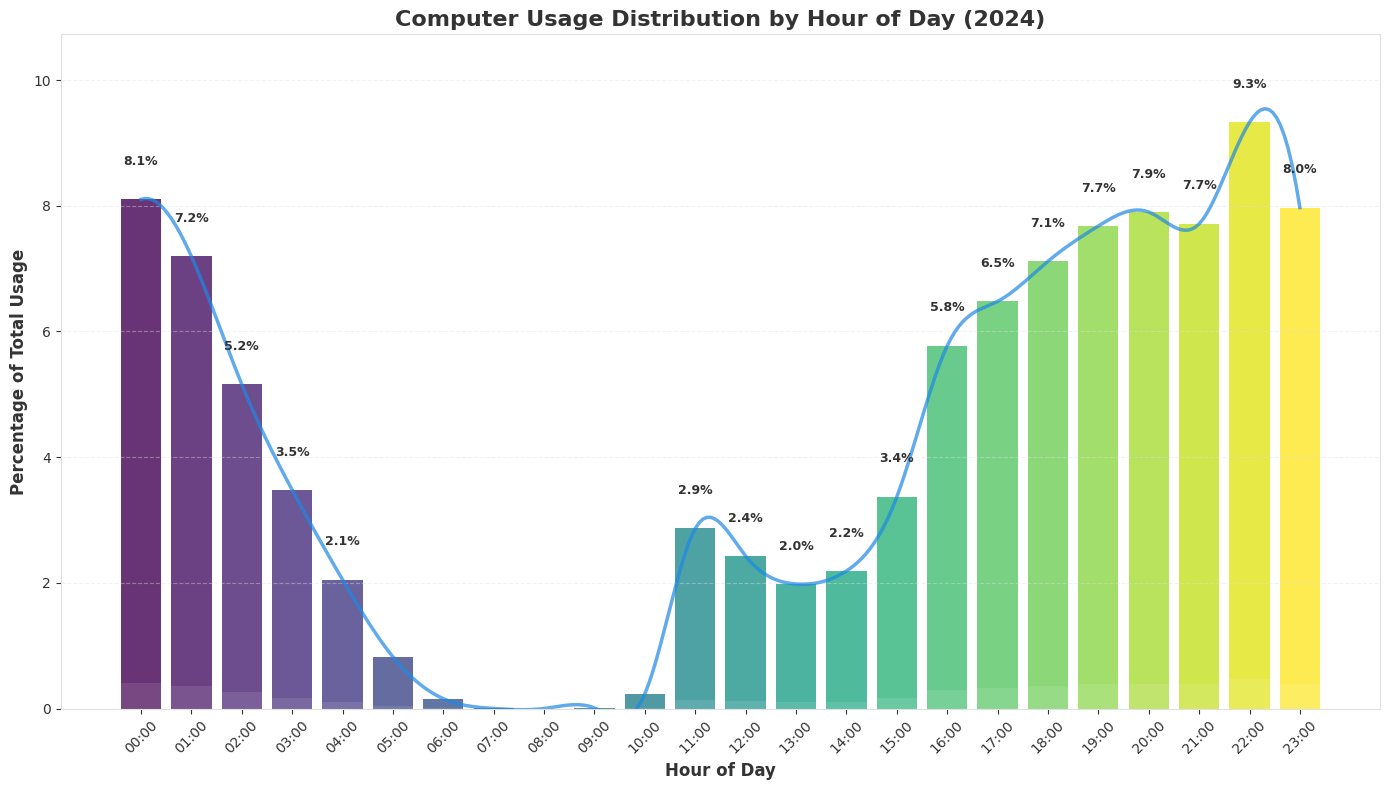

/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/1705010403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['month_name'] = merged_df['begin_date'].dt.strftime('%b')
/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/1705010403.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['month_num'] = merged_df['begin_date'].dt.month


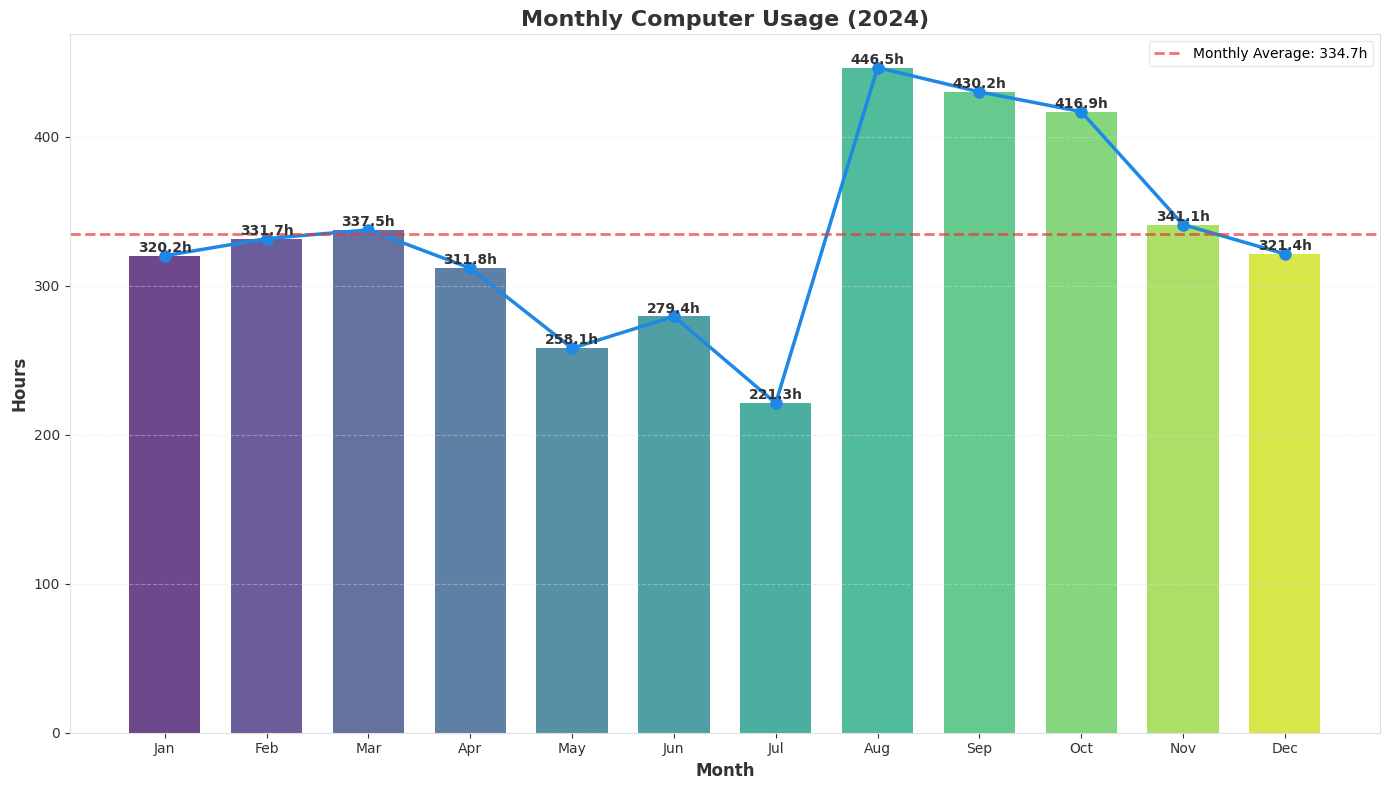

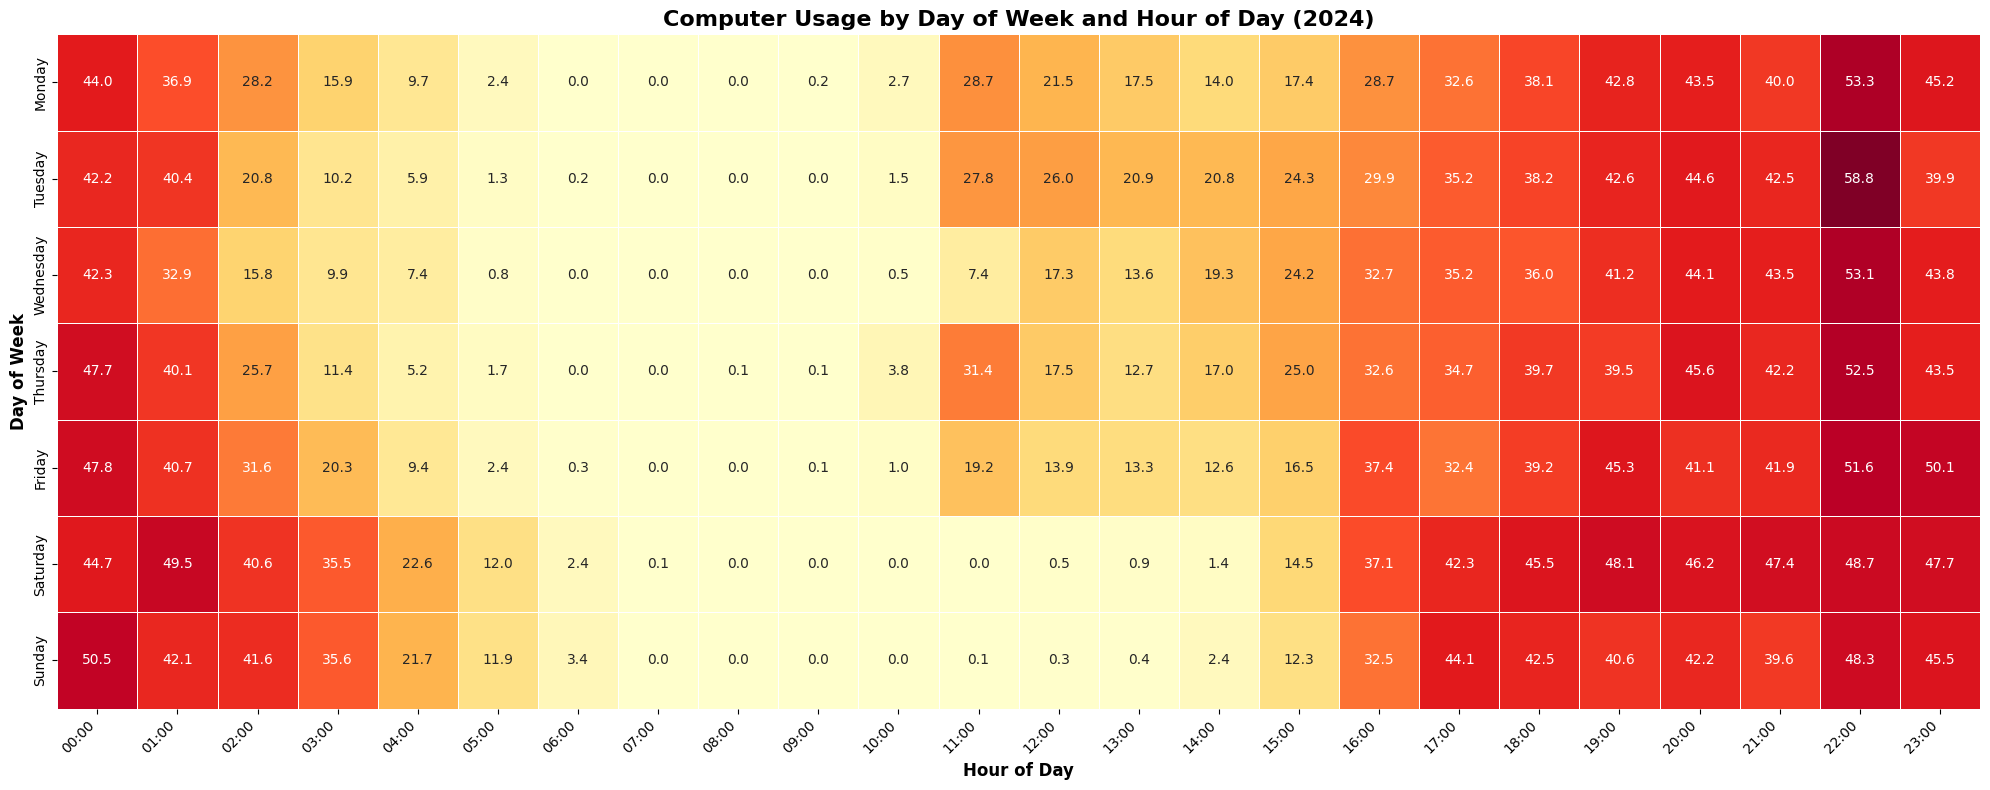


Heatmap Statistics:
Total hours logged: 3941.72

Top 5 most active time slots:
Tuesday at 22:00 - 58.84 hours
Monday at 22:00 - 53.28 hours
Wednesday at 22:00 - 53.06 hours
Thursday at 22:00 - 52.50 hours
Friday at 22:00 - 51.56 hours
           date      hours
0    2024-01-01   6.378916
1    2024-01-02  11.594200
2    2024-01-03   9.123391
3    2024-01-04   9.567604
4    2024-01-05   9.505766
..          ...        ...
358  2024-12-27   5.198889
359  2024-12-28   2.259722
360  2024-12-29   2.357222
361  2024-12-30   3.870000
362  2024-12-31   3.170556

[363 rows x 2 columns]


/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/2321284170.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 0.90, 0.96])


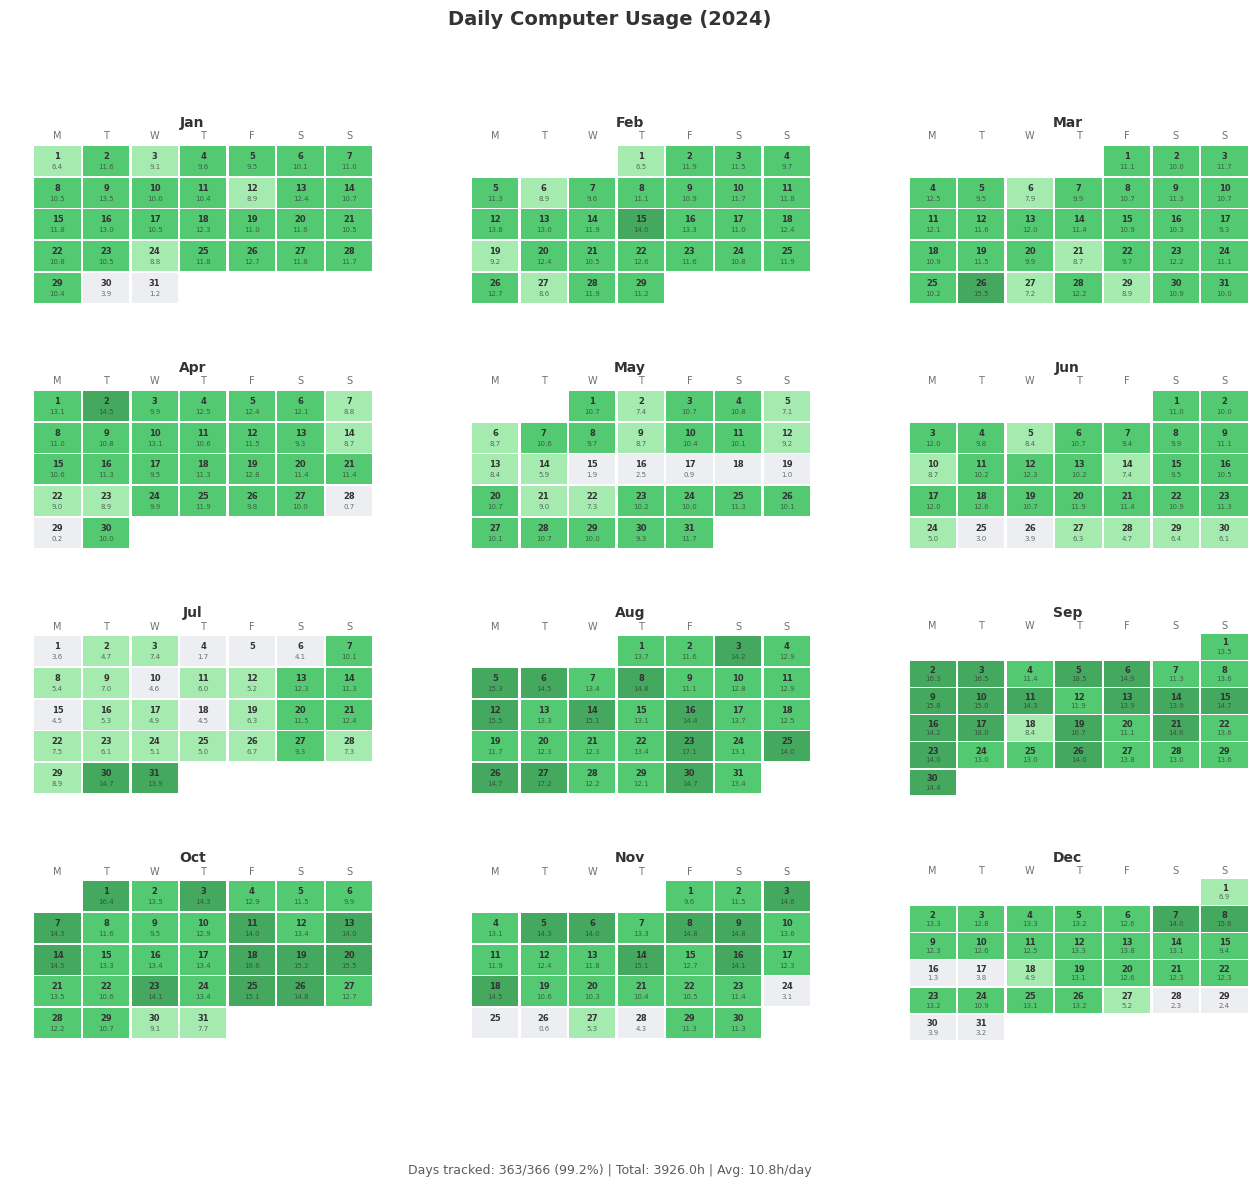

Creating dark theme visualizations...


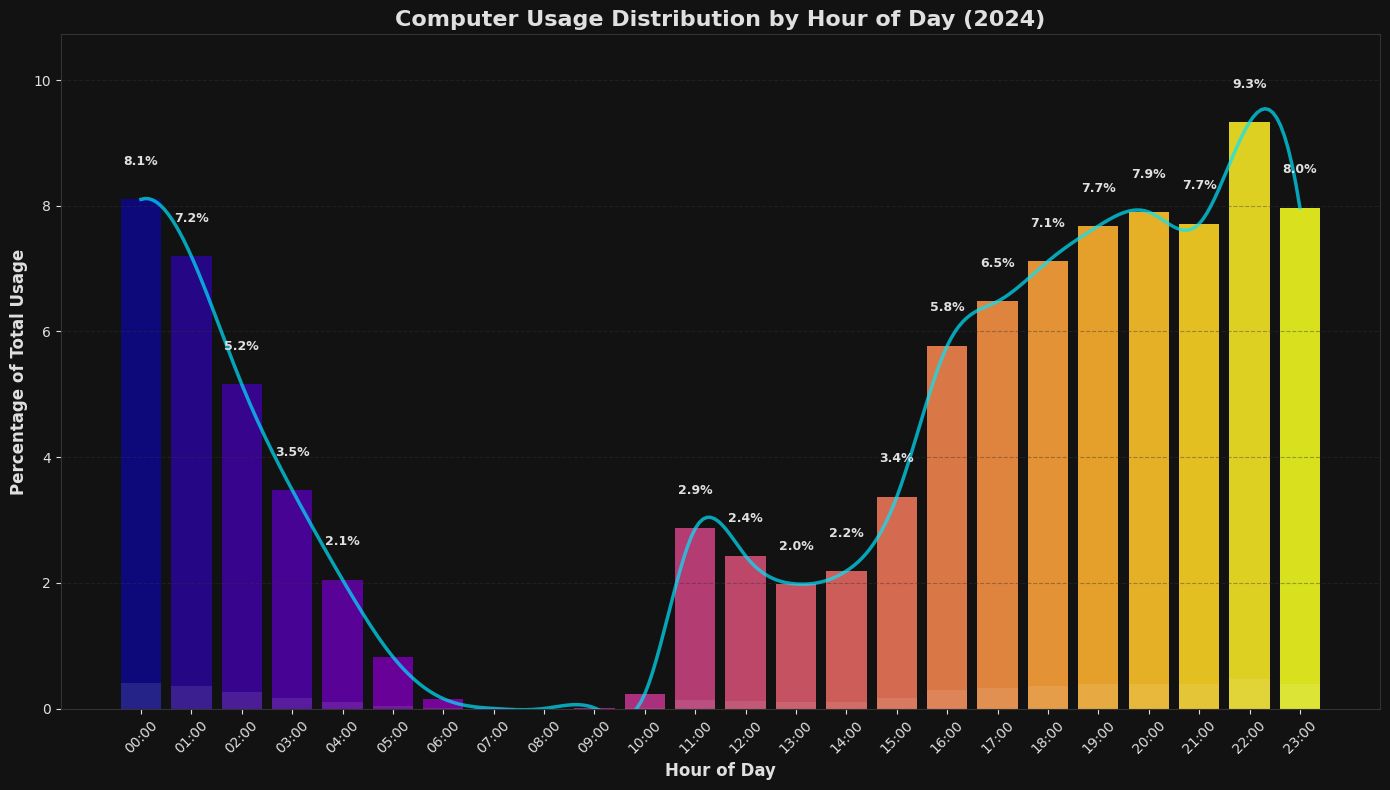

/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/1705010403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['month_name'] = merged_df['begin_date'].dt.strftime('%b')
/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/1705010403.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['month_num'] = merged_df['begin_date'].dt.month


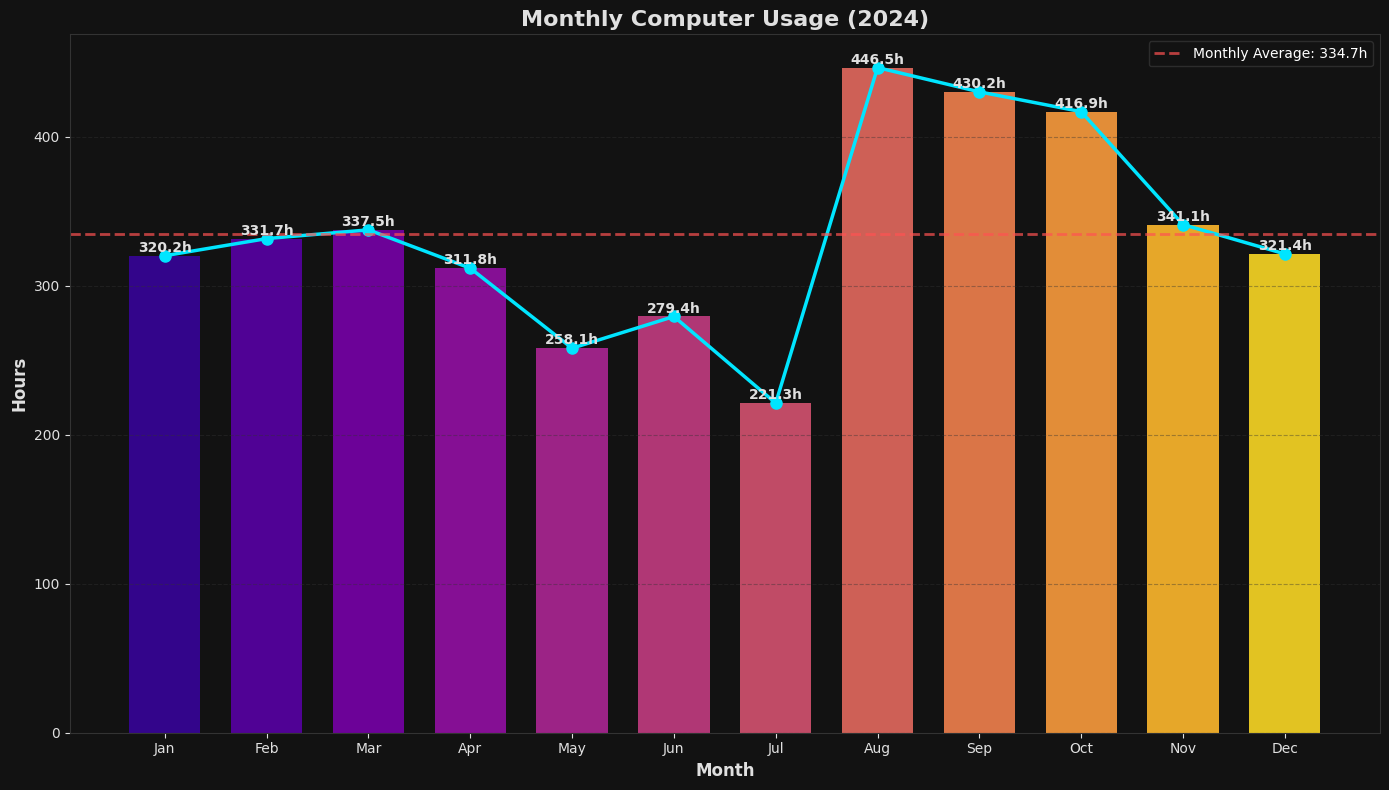

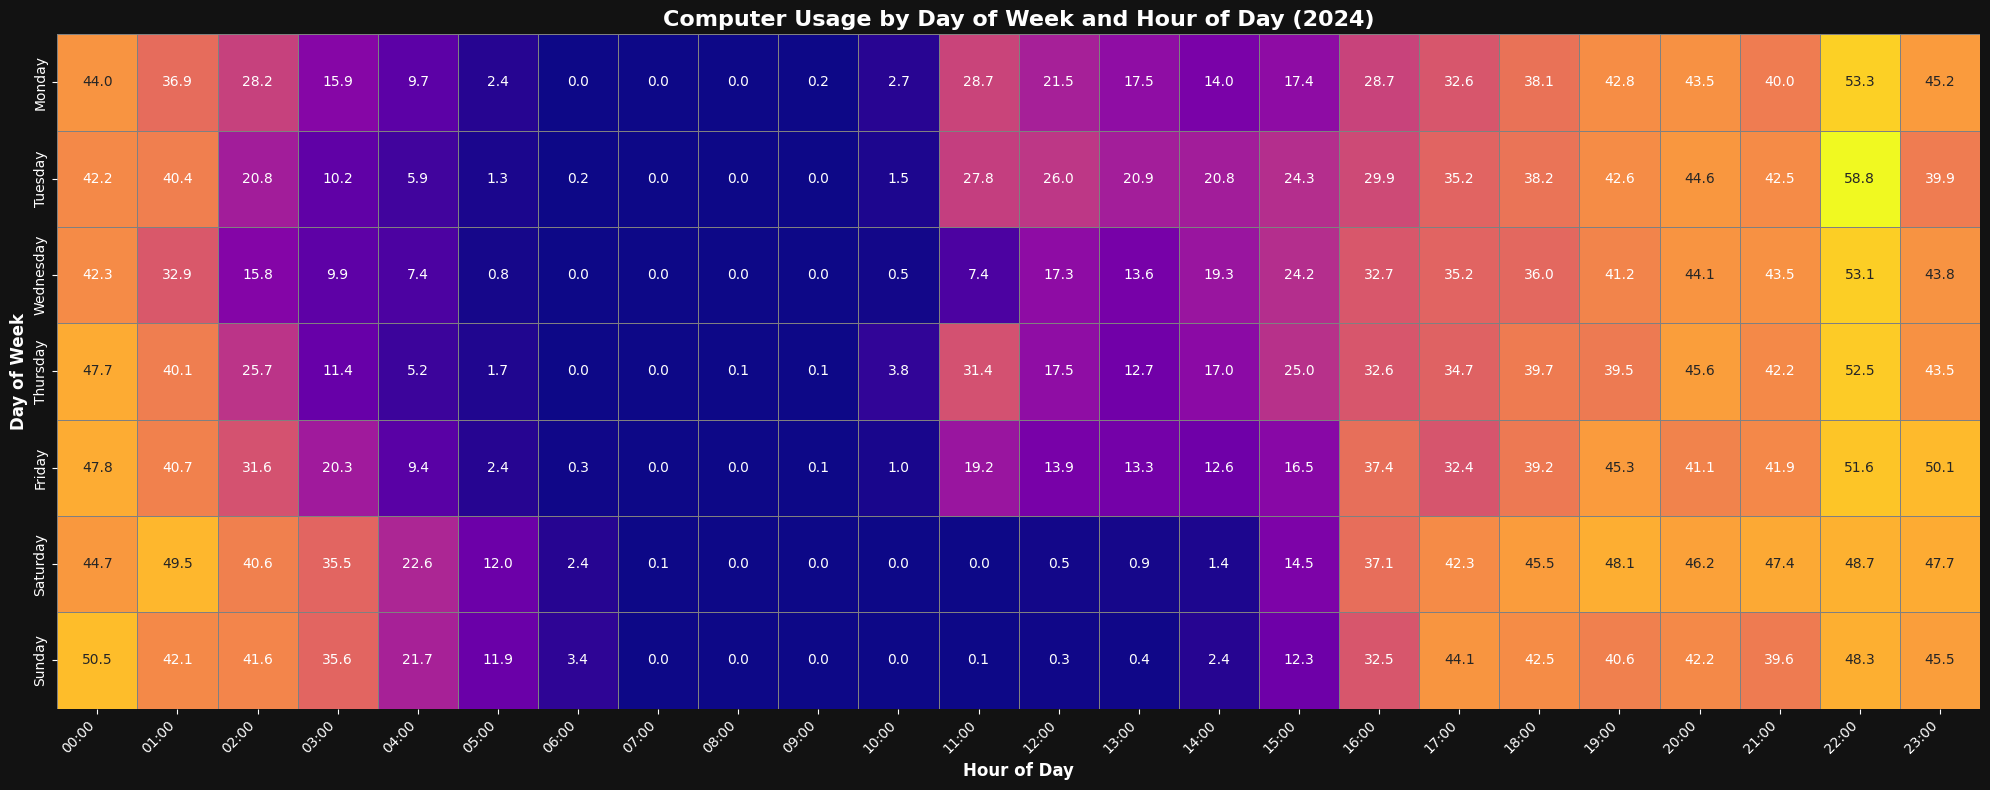


Heatmap Statistics:
Total hours logged: 3941.72

Top 5 most active time slots:
Tuesday at 22:00 - 58.84 hours
Monday at 22:00 - 53.28 hours
Wednesday at 22:00 - 53.06 hours
Thursday at 22:00 - 52.50 hours
Friday at 22:00 - 51.56 hours
           date      hours
0    2024-01-01   6.378916
1    2024-01-02  11.594200
2    2024-01-03   9.123391
3    2024-01-04   9.567604
4    2024-01-05   9.505766
..          ...        ...
358  2024-12-27   5.198889
359  2024-12-28   2.259722
360  2024-12-29   2.357222
361  2024-12-30   3.870000
362  2024-12-31   3.170556

[363 rows x 2 columns]


/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_27008/2321284170.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 0.90, 0.96])


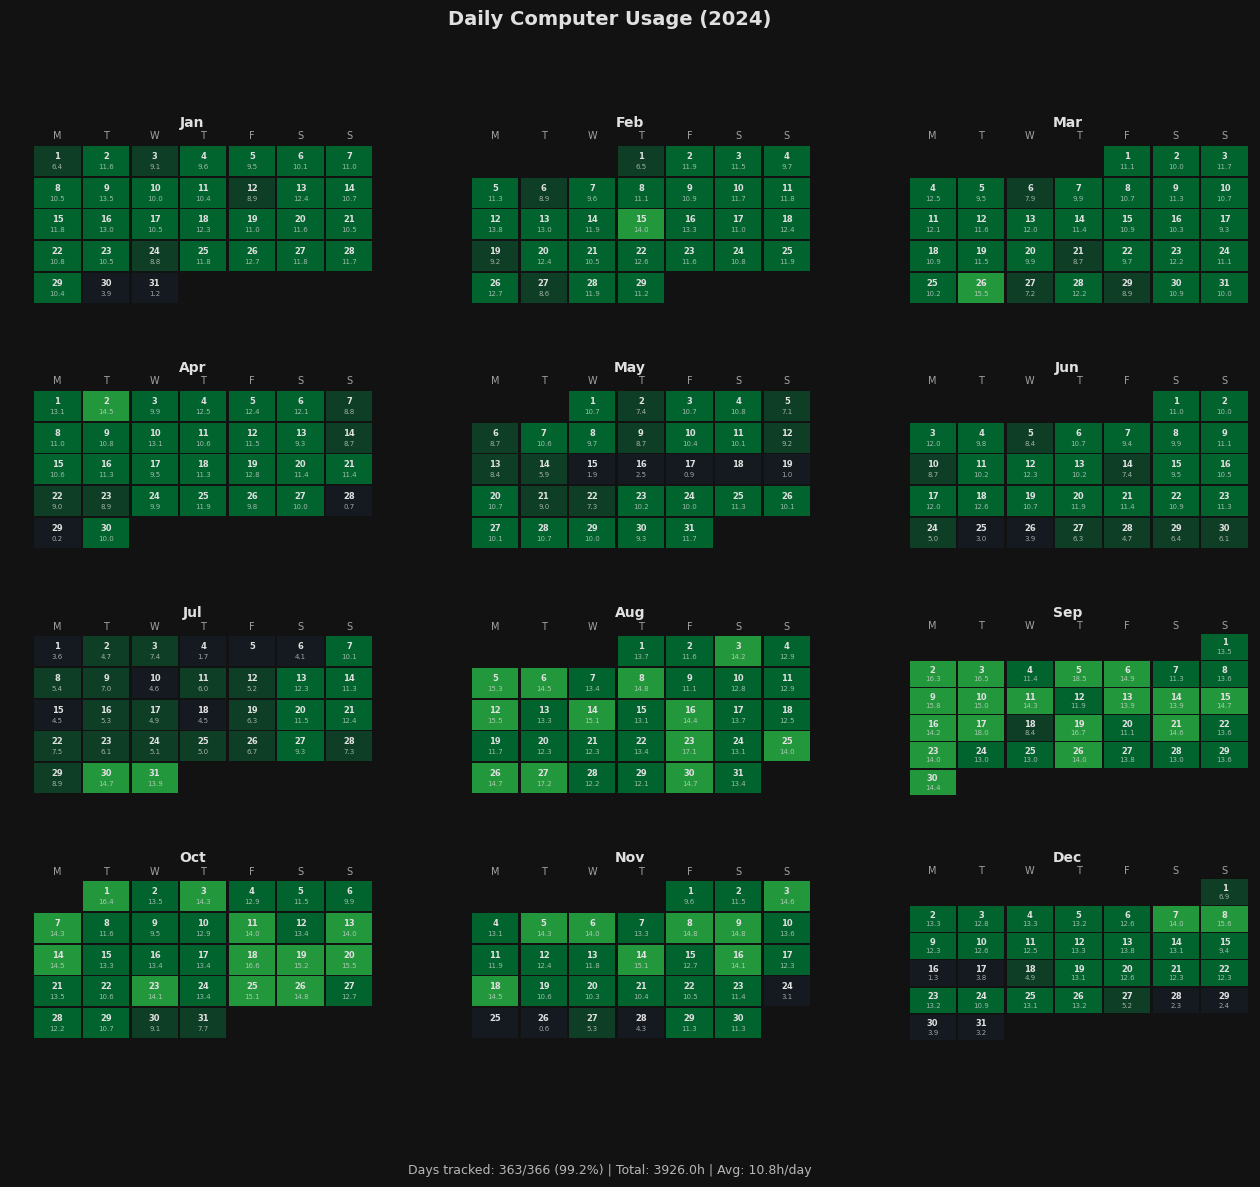

Total hours tracked (removing overlaps): 4400.94

Average daily computer usage: 11.06 hours
Most active day of week: Saturday
Most active hour of day: 22:00

Visualizations have been displayed in the notebook and saved in 'visualizations_light' and 'visualizations_dark' folders.


In [28]:
light_figures = create_all_visualizations(daily_usage, weekly_usage, hourly_dist, dow_dist, merged_df, 'light', True)
dark_figures = create_all_visualizations(daily_usage, weekly_usage, hourly_dist, dow_dist, merged_df, 'dark', True)

print(f"Total hours tracked (removing overlaps): {total_hours_non_overlapping:.2f}")

print("\nAverage daily computer usage: {:.2f} hours".format(daily_usage['hours'].mean()))
print("Most active day of week: {}".format(dow_dist.sort_values('hours', ascending=False).iloc[0]['day_name']))
print("Most active hour of day: {:02.0f}:00".format(hourly_dist.sort_values('duration', ascending=False).iloc[0]['hour']))

print("\nVisualizations have been displayed in the notebook and saved in 'visualizations_light' and 'visualizations_dark' folders.")